In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import geopandas as gp
import pycountry

import sys

sys.path.insert(0, "../Notebooks/Functions")
import StatsFunctions as MF

In [2]:
DF = pd.read_csv("../Data/avgIQpercountry.csv")

In [3]:
#Renamed for easier access
DF.rename(
    {
        "Average IQ": "IQ",
        "Literacy Rate": "Literacy",
        "Nobel Prices": "Nobels",
        "HDI (2021)": "HDI",
        "Mean years of schooling - 2021": "SchoolYears",
        " GNI - 2021": "GNI",
        "Population - 2023": "Population",
    },
    axis=1,
    inplace=True,
)

In [4]:
DF = DF.astype({"Population": "float64"})

In [5]:
order = DF["Country"].copy().to_list()
colours = dict(zip(DF["Continent"].unique(), sns.color_palette("bright", 8)))
kwargs = {"hue": "Continent", "palette": colours, "edgecolor": "black", "alpha": 0.6}
# At a very late stage made a colour pallete for continents only

In [6]:
DF.dropna(how='any', inplace=True)

In [7]:
DF["Continent"].unique()

array(['Asia', 'Europe', 'North America', 'Oceania', 'Europe/Asia',
       'Central America', 'South America', 'Africa'], dtype=object)

In [8]:
#wanted to see if group by will be useful, but seaborn does it for me already
Continents = DF.groupby("Continent").agg(
    {"Literacy": MF.mean, "Population": "sum", "Nobels": "sum"}
)

In [9]:
#Thought might use later
less_10 = (
    DF.query("Population < 10000000")
    .groupby("Continent")
    .agg({"Literacy": MF.mean, "Population": "sum", "Nobels": "sum"})
    .sum()
)
over_10 = (
    DF.query("Population > 10000000")
    .groupby("Continent")
    .agg({"Literacy": MF.mean, "Population": "sum", "Nobels": "sum"})
)

In [10]:

#Not significant
fig = px.sunburst(
    DF.query("Population > 50_000_000"),
    path=["Continent", "Country"],
    values="Population",
    width=1000,
    height=600,
    title="Countries by population",
)
fig.show()

In [11]:
def heatmap(data, title=""):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(corr.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=45)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)

    matrix = pd.DataFrame(data.corr(method="pearson")).round(2)
    
    for i in range(len(matrix)):
        for j in range(len(matrix.iloc[0])):
            text = ax.text(j, i, matrix.iloc[i, j], ha="center", va="center", color="w")
    ax.set_title(title, pad=20)


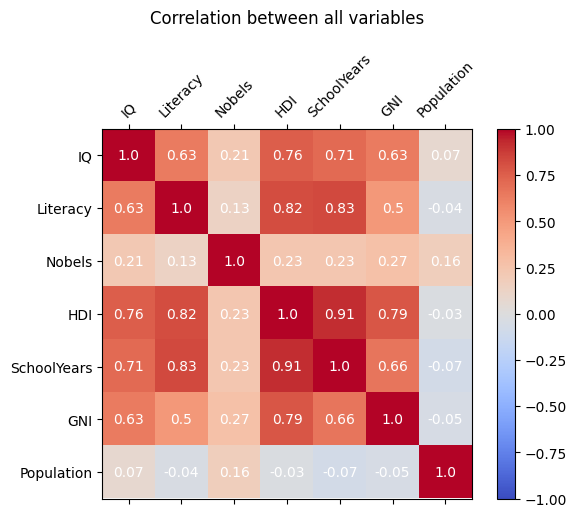

In [12]:
heatmap(
    DF.select_dtypes(include=np.number).drop("Rank", axis =1 ),    
    title="Correlation between all variables",
)


Text(0.5, 1.0, 'Distribution of average IQ')

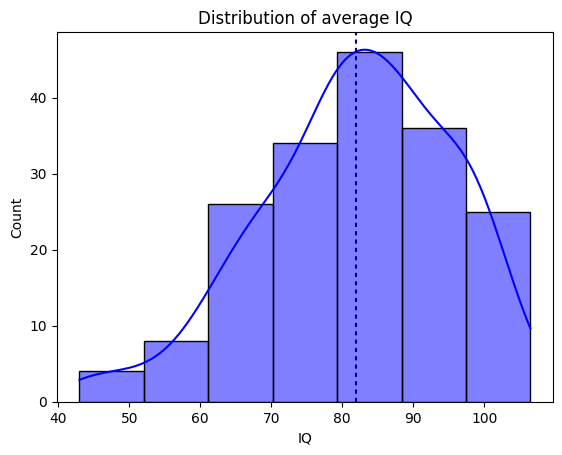

In [13]:
# decided to check average IQ and see how useful it would be
histIQ = sns.histplot(DF, x="IQ", bins=7, kde=True, color="blue")

plt.axvline(
    MF.mean(DF["IQ"]), color="darkblue", label="mean", dashes=(2, 2)
)  # TK change mean to my function

plt.title("Distribution of average IQ")

In [14]:
DF["Continent"].value_counts()

Continent
Africa             49
Asia               44
Europe             41
Central America    19
South America      12
Oceania             8
North America       3
Europe/Asia         3
Name: count, dtype: int64

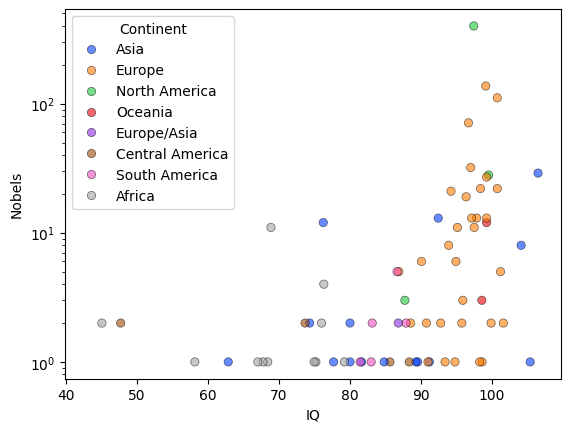

In [15]:
# Desided exprlore correlation between average IQ of a country with how many novel prises the continent won.
# Europe is on average smarter and have more entries due to more countries, but America is a clear outlier
# sns.scatterplot(data=DF, x="IQ", y="Nobels", hue="Continent", palette=colours, edgecolor = "black", alpha = 0.5)
sns.scatterplot(data=DF, x="IQ", y="Nobels", **kwargs)

plt.yscale("log")

Text(0.5, 1.0, 'Distribution of IQ for each continent')

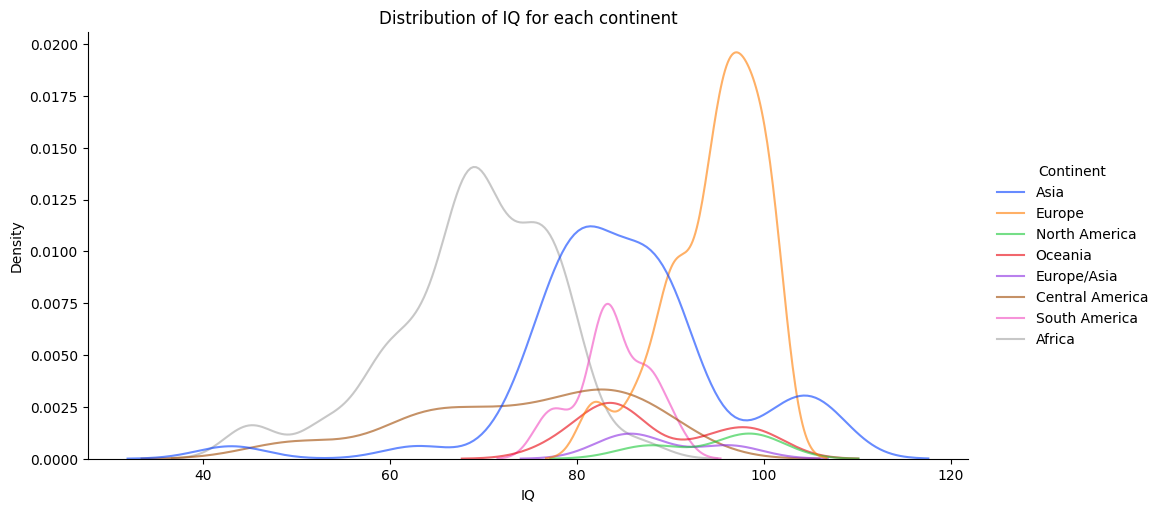

In [16]:
sns.displot(data=DF, x="IQ", **{i:kwargs[i] for i in kwargs if i not in ['edgecolor']}, aspect = 2, kind = "kde", bw_adjust=0.7)

plt.title("Distribution of IQ for each continent")

Text(0.5, 0.98, 'Relationship between HDI and GNI in both linear and logarithmic scales')

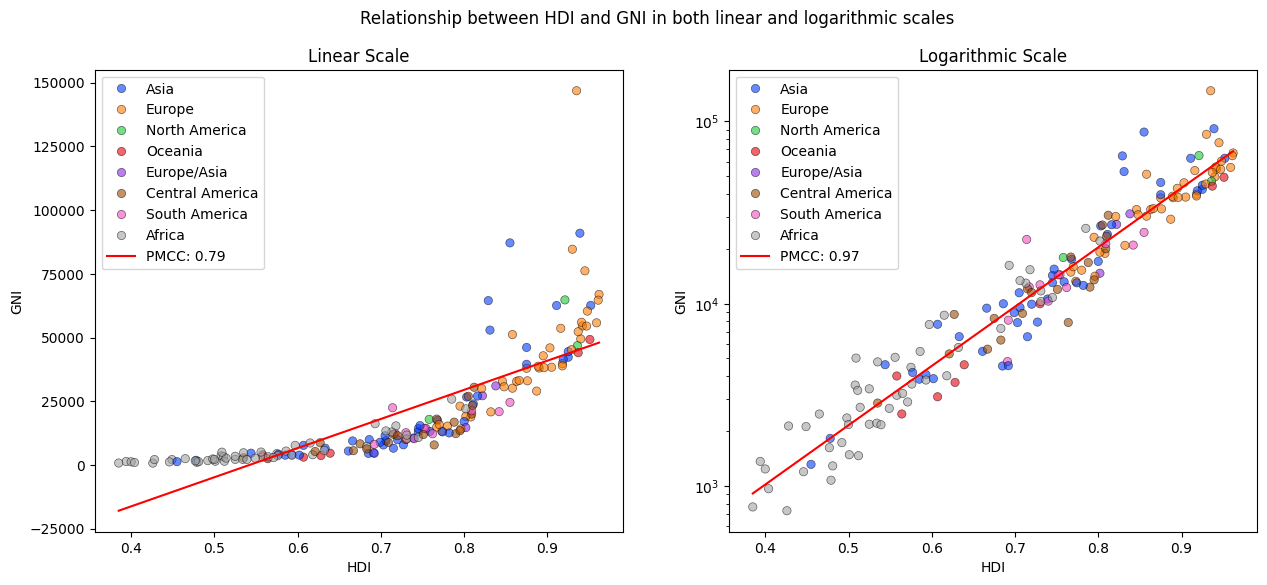

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
m,q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["GNI"].to_list())
m1,q1, cor1 = MF.linear_regression(DF["HDI"].to_list(), np.log10(DF["GNI"].to_list()))
sns.scatterplot(data=DF, y="GNI", x="HDI", **kwargs, ax = axes[0], )  
sns.lineplot(x = DF["HDI"], y = m*DF["HDI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = axes[0])
axes[0].set_title("Linear Scale")

###
axes[1].set_yscale('log')
X = np.column_stack((np.ones_like(DF["HDI"]), DF["HDI"]))
y_log = np.log(DF["GNI"])
theta = np.linalg.inv(X.T @ X) @ X.T @ y_log
# Predict y values using the linear regression model
y_pred_log = X @ theta

# Plot the linear regression line
sns.scatterplot(data=DF, y="GNI", x="HDI", **kwargs, ax = axes[1])  
sns.lineplot(x = DF["HDI"], y = np.exp(y_pred_log) , label = f'PMCC: {round(cor1, 2)}', color = "red", ax = axes[1])
axes[1].set_title("Logarithmic Scale")

fig.suptitle('Relationship between HDI and GNI in both linear and logarithmic scales')

#more the countryb invests in people -> they tend to earn and save more money
#Significant? [TK]


In [49]:
DF.sort_values(by = "HDI", ascending=False).query("Continent == 'Europe/Asia'")

,Rank,Country,IQ,Continent,Literacy,Nobels,HDI,SchoolYears,GNI,Population
75,76,Türkiye,86.80,Europe/Asia,0.96,2,0.838,8.6,31033.0,85816199.0
33,34,Russia,96.29,Europe/Asia,1.00,0,0.822,12.8,27166.0,144444359.0
83,84,Georgia,84.50,Europe/Asia,1.00,0,0.802,12.8,14664.0,3728282.0


(0.35615, 1.01)

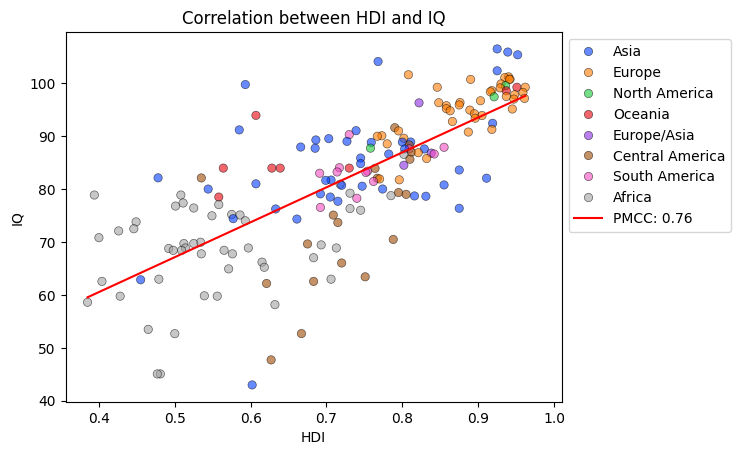

In [42]:
fig, ax = plt.subplots()
m,q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["IQ"].to_list())

sns.scatterplot(data = DF, x = "HDI", y = "IQ", **kwargs)
sns.lineplot(x = DF["HDI"], y = m*DF["HDI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Correlation between HDI and IQ")
plt.xlim((None, 1.01))


Text(0.5, 0.98, 'Relationship between GNI and IQ in both linear and logarithmic scales')

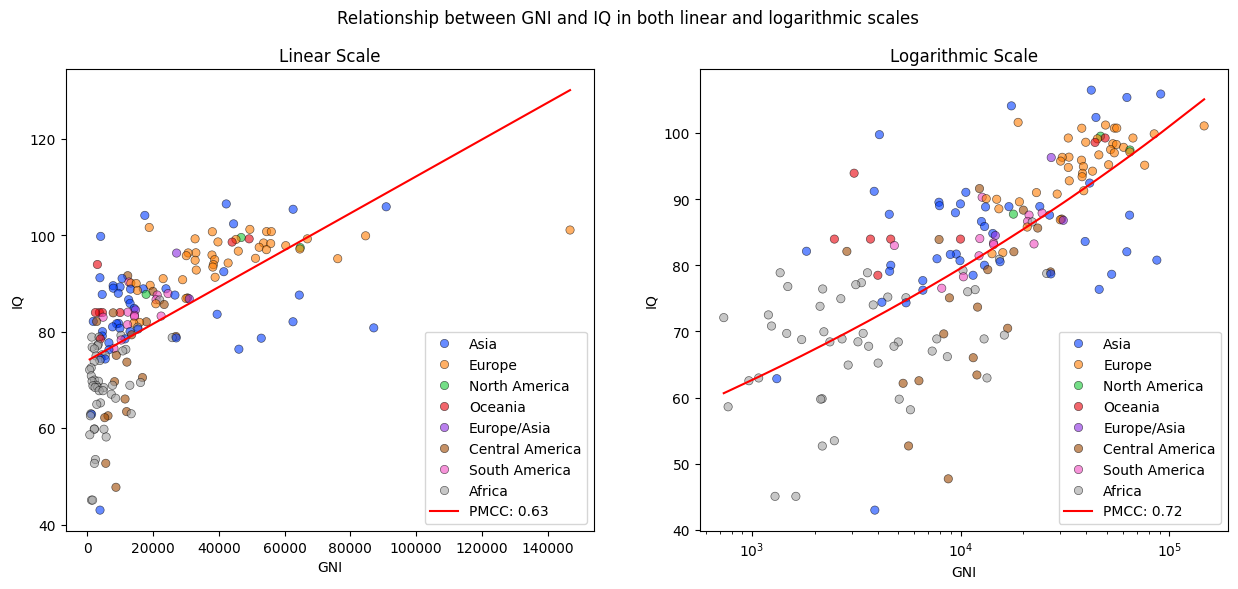

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
m,q, cor = MF.linear_regression(DF["GNI"].to_list(), DF["IQ"].to_list())
sns.scatterplot(data=DF, y="IQ", x="GNI", **kwargs, ax = axes[0])  
sns.lineplot(x = DF["GNI"], y = m*DF["GNI"] + q , label = f'PMCC: {round(cor, 2)}', color = "red", ax = axes[0])
axes[0].set_title("Linear Scale")



###



m1,q1, cor1 = MF.linear_regression(DF["IQ"].to_list(), np.log10(DF["GNI"].to_list()))
axes[1].set_xscale('log')  # Set x-axis to log scale
X_log = np.column_stack((np.ones_like(np.log(DF["GNI"])), np.log(DF["GNI"])))
y_log = np.log(DF["IQ"])
theta = np.linalg.inv(X_log.T @ X_log) @ X_log.T @ y_log
y_pred_log = X_log @ theta


# Plot the linear regression line
sns.scatterplot(data=DF, y="IQ", x="GNI", **kwargs, ax = axes[1])  
sns.lineplot(x = DF["GNI"], y =np.exp(y_pred_log), color='red',  label = f'PMCC: {round(cor1, 2)}', ax = axes[1])

axes[1].set_title("Logarithmic Scale")

fig.suptitle('Relationship between GNI and IQ in both linear and logarithmic scales')

#more money -> access to education -> smarter on average

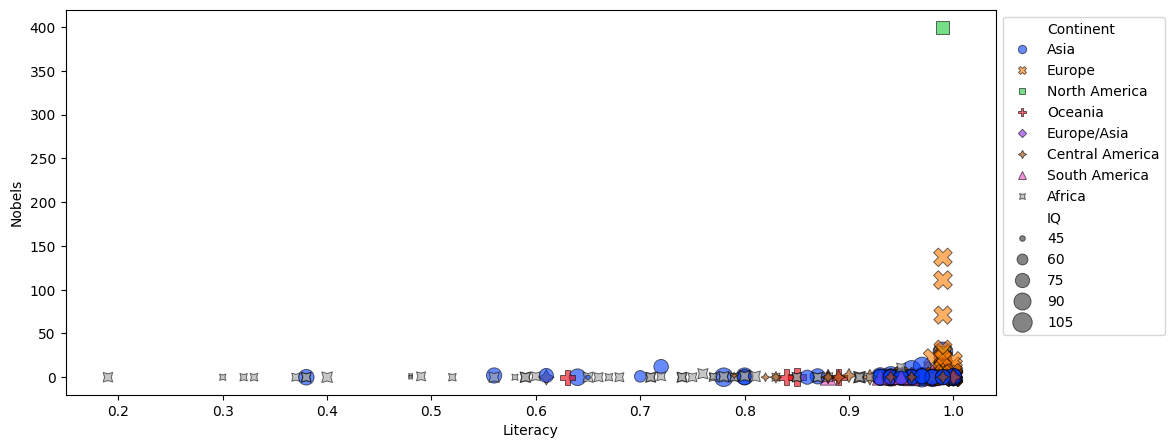

In [20]:
fig, ax = plt.subplots(figsize = (12,5))
sns.scatterplot(data=DF, x="Literacy", y="Nobels", **kwargs, size = "IQ", sizes = (10, 200), style = "Continent") 
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.xlim((8, 15))
# plt.ylim((0.7, 1.05))

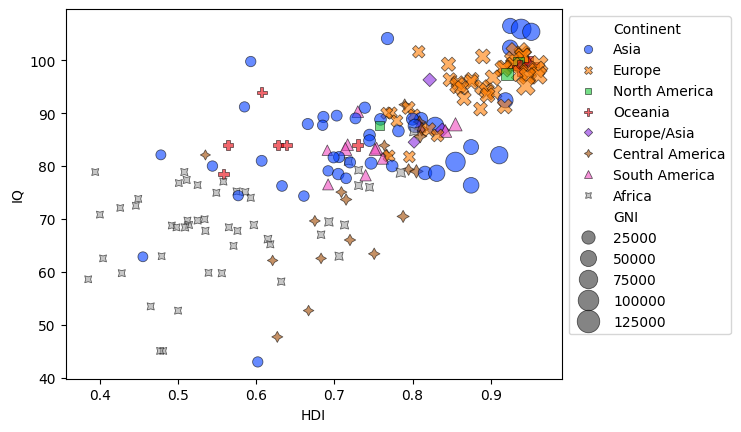

In [21]:
fig, ax = plt.subplots()
sns.scatterplot(data = DF, x = "HDI", y = "IQ", size="GNI", **kwargs, style = "Continent", sizes=(50, 300))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


Text(0.5, 1.0, 'Distribution of IQ accross regions')

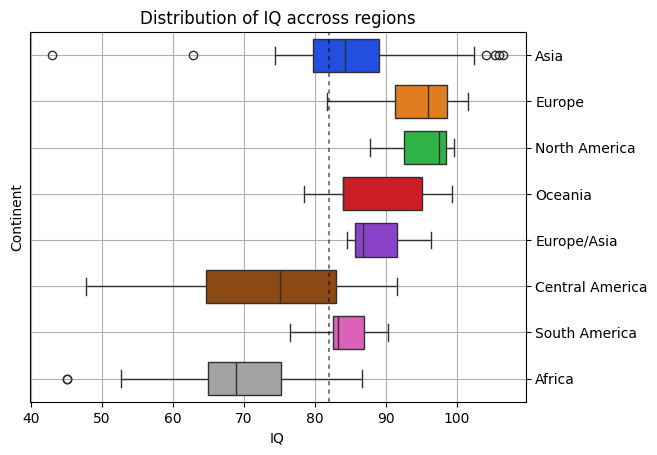

In [22]:
ax = sns.boxplot(
    data=DF,
    x="IQ",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2
)
plt.axvline(
    x=MF.mean(DF["IQ"]),
    color="black",
    alpha = 0.5,
    dashes=(2, 2),
)
ax.grid()
# ax.tick_params(axis="y", rotation=45, )
ax.yaxis.tick_right()


#NA has only 3 countries

plt.title("Distribution of IQ accross regions")

Text(0.5, 1.0, 'Distribution of HDI accross regions')

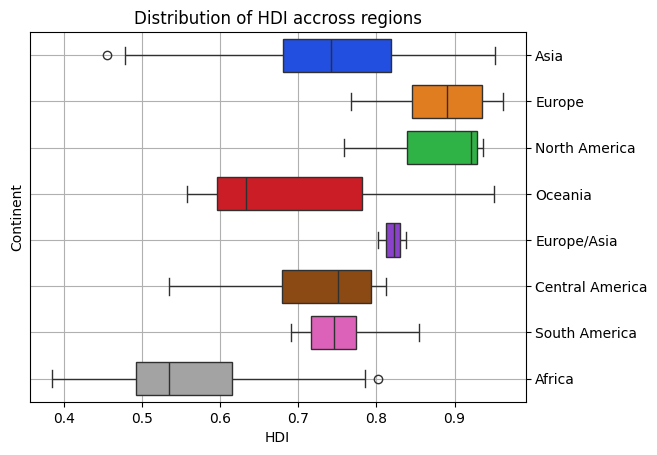

In [23]:
ax = sns.boxplot(
    data=DF,
    x="HDI",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2
)

ax.grid()
# ax.tick_params(axis="y", rotation=45, )
ax.yaxis.tick_right()


#NA has only 3 countries

plt.title("Distribution of HDI accross regions")

Text(0.5, 1.0, 'Distribution of GNI accross regions')

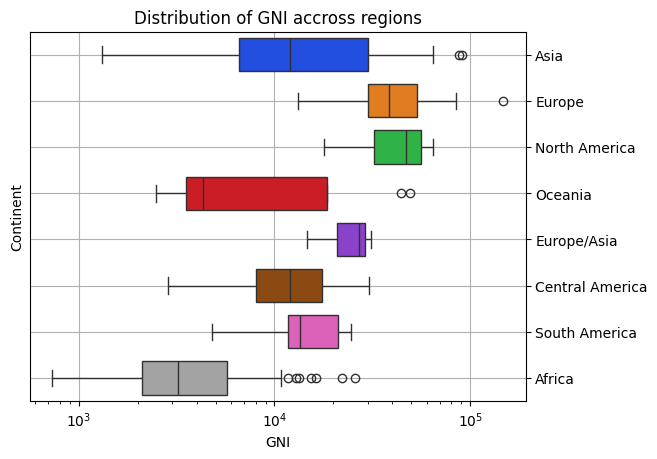

In [52]:
ax = sns.boxplot(
    data=DF,
    x="GNI",
    y="Continent",
    gap=0.4,
    **{i: kwargs[i] for i in kwargs if i not in ["edgecolor", "alpha"]},
    legend="auto",
    width=1.2
)

ax.grid()
# ax.tick_params(axis="y", rotation=45, )
ax.yaxis.tick_right()
ax.set_xscale("log")

#NA has only 3 countries

plt.title("Distribution of GNI accross regions")

Text(0.5, 1.0, 'Correlation between years spent in school and IQ')

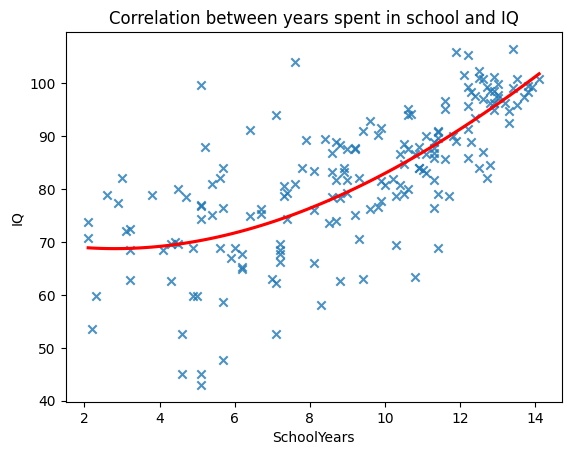

In [24]:
fig, ax = plt.subplots()
sns.regplot(DF, x = "SchoolYears", y = "IQ", order=3, ci=0, marker="x", line_kws=dict(color="r")) #TK: come up with own funciton???
plt.title("Correlation between years spent in school and IQ") #dimitris discuss

Text(0.5, 1.0, 'Correlation between years spent in school and IQ')

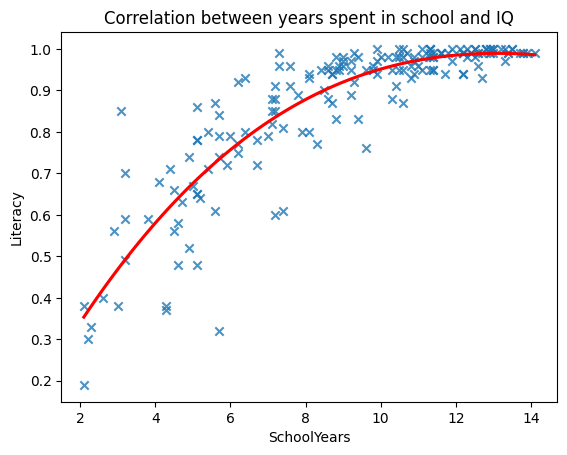

In [25]:
fig, ax = plt.subplots()
sns.regplot(DF, x = "SchoolYears", y = "Literacy", order=3, ci=0, marker="x", line_kws=dict(color="r")) #TK: come up with own funciton???
plt.title("Correlation between years spent in school and IQ") #dimitris discuss

In [26]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

C:\Users\dima1\AppData\Local\Temp\ipykernel_30104\2282005331.py:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



In [27]:
rank_location = DF[::]

world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
rank_location['ISO_alpha'] = rank_location['Country'].apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) else None)



C:\Users\dima1\AppData\Local\Temp\ipykernel_30104\1021141429.py:3: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

C:\Users\dima1\AppData\Local\Temp\ipykernel_30104\1021141429.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
DF.loc[DF["Country"] == "United States", "Country"] = "United States of America"


In [29]:
rank_location.merge(world[["name", "geometry", "iso_a3"]], left_on="Country", right_on = "name", how = "left")
## make iso_alpha to iso_3 if NaN, leave otherwise



,Rank,Country,IQ,Continent,Literacy,Nobels,HDI,SchoolYears,GNI,Population,ISO_alpha,name,geometry,iso_a3
0,1,Japan,106.48,Asia,0.99,29,0.925,13.4,42274.0,1.232945e+08,JPN,Japan,"MULTIPOLYGON (((141.88460 39.18086, 140.95949 ...",JPN
1,3,Singapore,105.89,Asia,0.97,0,0.939,11.9,90919.0,6.014723e+06,SGP,NaN,None,NaN
2,4,Hong Kong,105.37,Asia,0.94,1,0.952,12.2,62607.0,7.491609e+06,HKG,NaN,None,NaN
3,5,China,104.10,Asia,0.96,8,0.768,7.6,17504.0,1.425671e+09,CHN,China,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...",CHN
4,6,South Korea,102.35,Asia,0.98,0,0.925,12.5,44501.0,5.178406e+07,None,South Korea,"POLYGON ((126.17476 37.74969, 126.23734 37.840...",KOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,189,Gambia,52.68,Africa,0.58,0,0.500,4.6,2172.0,2.773168e+06,GMB,Gambia,"POLYGON ((-16.71373 13.59496, -15.62460 13.623...",GMB
175,190,Guatemala,47.72,Central America,0.79,2,0.627,5.7,8723.0,1.809203e+07,GTM,Guatemala,"POLYGON ((-92.22775 14.53883, -92.20323 14.830...",GTM
176,191,Liberia,45.07,Africa,0.48,2,0.481,5.1,1289.0,5.418377e+06,LBR,Liberia,"POLYGON ((-8.43930 7.68604, -8.48545 7.39521, ...",LBR
177,192,Sierra Leone,45.07,Africa,0.48,0,0.477,4.6,1622.0,8.791092e+06,SLE,Sierra Leone,"POLYGON ((-13.24655 8.90305, -12.71196 9.34271...",SLE


In [30]:
fig = px.choropleth(
    rank_location.merge(world[["name", "geometry", "iso_a3"]], left_on="Country", right_on = "name", how = "left"),
    locations='iso_a3',
    color='IQ',
    color_continuous_scale='YlOrRd',
    hover_data="name"
    
)
fig.update_layout(margin={"r":350,"t":50,"l":100,"b":0}, title_text='Average IQ of countries', title_x=0.5, autosize = True)


fig.show()

In [31]:
fig = px.choropleth(
    rank_location.merge(world[["name", "geometry", "iso_a3"]], left_on="Country", right_on = "name", how = "left"),
    locations='iso_a3',
    color='Literacy',
    color_continuous_scale='YlOrRd',

    
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_layout(title_text='Average literacy index of schooling in countries', title_x=0.5, autosize = True)


fig.show()

In [32]:
fig = px.choropleth(
    rank_location.merge(world[["name", "geometry", "iso_a3"]], left_on="Country", right_on = "name", how = "left"),
    locations='iso_a3',
    color='HDI',
    color_continuous_scale='YlOrRd',

    
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_layout(title_text='HDI index of schooling in countries', title_x=0.5, autosize = True)


fig.show()

In [33]:
fig = px.choropleth(
    rank_location.merge(world[["name", "geometry", "iso_a3"]], left_on="Country", right_on = "name", how = "left"),
    locations='iso_a3',
    color='GNI',
    color_continuous_scale='YlOrRd',
    
    
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_layout(title_text='HDI index of schooling in countries', title_x=0.5, autosize = True)


fig.show()

Text(0.5, 1.0, 'Most populated counties')

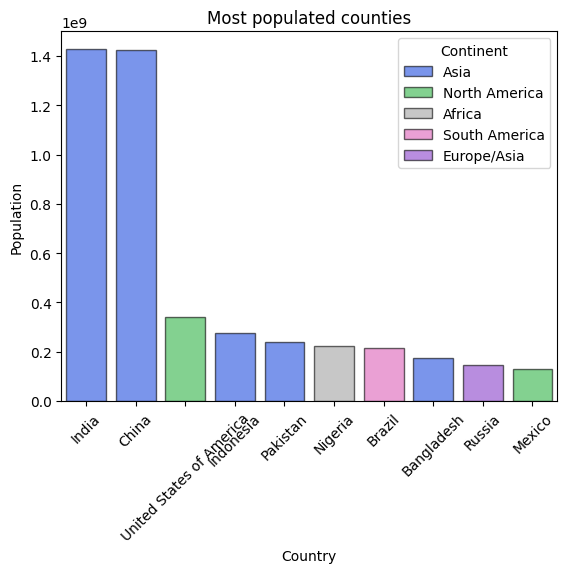

In [34]:
sns.barplot(DF.sort_values(by = "Population", ascending=False).head(10), x= "Country", y = "Population", **kwargs)
plt.xticks(rotation = 45)
plt.title("Most populated counties") #TK - not significant

Text(0.5, 1.0, 'Correlation between HDI and IQ for each country')

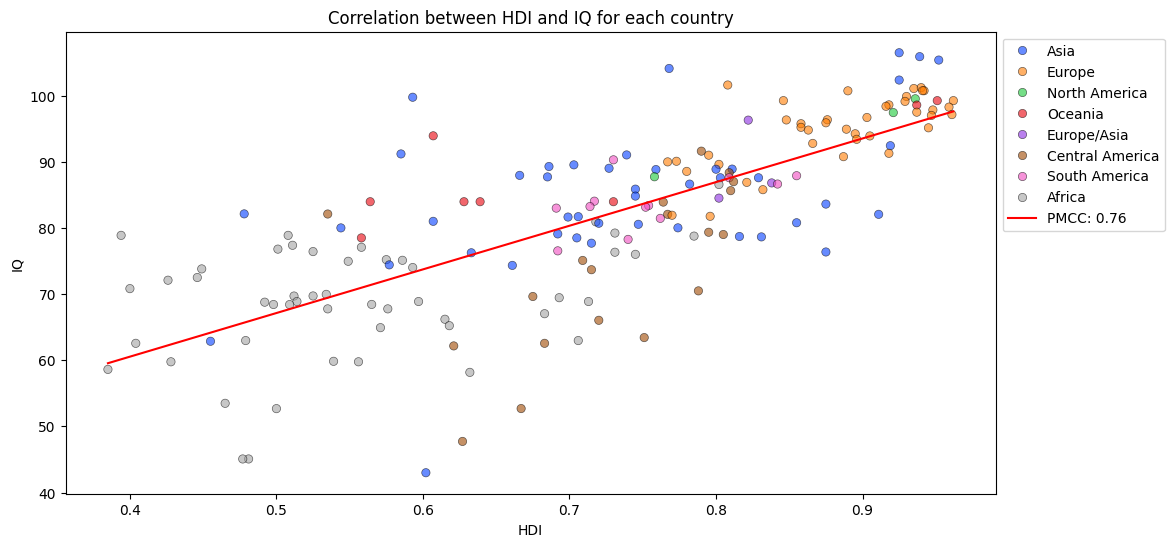

In [35]:
m,q, cor = MF.linear_regression(DF["HDI"].to_list(), DF["IQ"].to_list())

fig, ax = plt.subplots(figsize = (12,6))
sns.scatterplot(data = DF, x = "HDI", y = "IQ", **kwargs)
sns.lineplot(x = DF["HDI"], y = m * DF["HDI"] + q, label = f'PMCC: {round(cor, 2)}', color = "red")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Correlation between HDI and IQ for each country")


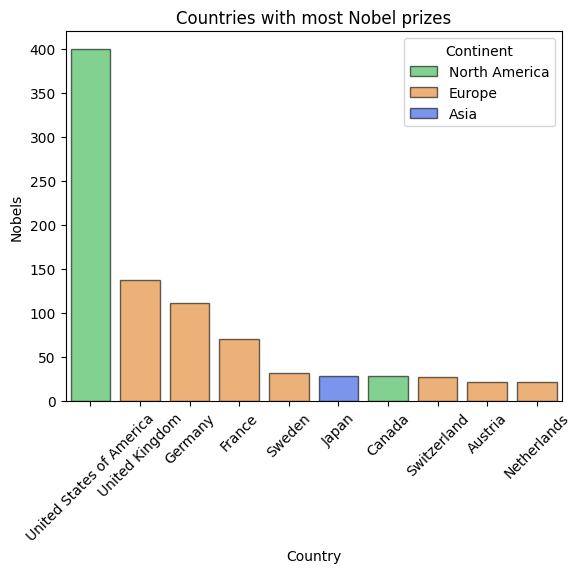

In [36]:
sns.barplot(DF.query("Nobels > 0").sort_values(by  = "Nobels", ascending=False).head(10), x = "Country", y = "Nobels",**kwargs)
plt.xticks(rotation = 45)
plt.title("Countries with most Nobel prizes")
plt.show()